In [1]:
# -*- coding: utf-8 -*-
import json
from hsic import HSIC
import matplotlib.pyplot as plt
import numpy as np
import openturns as ot


from plot import plot_tpd

from data_preparation import prepro_data_pce, preprocess_field_data, prepro_data_gp


BASE_DIRECTORY = '/Users/edgarjaber/Desktop/Articles/codes folder/Bayes-calibration-for-clogging-prognostics/DATA/'
SIMULATION_TIME = np.load(BASE_DIRECTORY + 'simulation_data/LHS/t_gv.npy', allow_pickle=True)
csv_file = BASE_DIRECTORY + 'field_data/field_data.csv'

input_dic = json.load(open(BASE_DIRECTORY + 'meta_data/SG_cleaning_conditioning.json'))
cleaning_dates = [input_dic['chemistry']['cleaning'][i]['time']/24 for i in range(len(input_dic['chemistry']['cleaning']))]


### NEW COLOR SCHEME FOR CHEMICAL CONDITIONING ###
colors_n_chem_cond = {'C1': {'name': r'$\chi_{1}$', 'low': 'gainsboro', 'high': 'silver'},
                      'C2': {'name': r'$\chi_{2}$', 'high': 'darkgray'}}

labels = [
    r"$\alpha$",
    r"$\beta$",
    r"$\epsilon_e$",
    r"$\epsilon_c$",
    r"$d_p$",
    r"$\Gamma_{p}(0)$",
    r"$a_v$"
]

labels = [
    r"$X_1$",
    r"$X_2$",
    r"$X_3$",
    r"$X_4$",
    r"$X_5$",
    r"$X_6$",
    r"$X_7$"
]

### MATPLOTLIB CONFIGURATION ###
plt.rcParams['figure.dpi']= 500
plt.rcParams['text.usetex'] = True

In [2]:
data, time_indices = preprocess_field_data(csv_file=csv_file, 
                                           operation_time=SIMULATION_TIME, 
                                           cleaning_dates=cleaning_dates, 
                                           with_time_division=True)

# Import Data

In [4]:
### DATA ###
lhs_hl = np.load('/Users/edgarjaber/Desktop/codes.nosync/calibration_full/DATA/gv_900/code_data/x_theta_t/LHS/doe_hl.npy', allow_pickle=True)
lhs_cl = np.load('/Users/edgarjaber/Desktop/codes.nosync/calibration_full/DATA/gv_900/code_data/x_theta_t/LHS/doe_cl.npy', allow_pickle=True)

n_max = lhs_hl.shape[0]
n_samp = 1000

X, y = prepro_data_pce(lhs_hl, lhs_cl, n_max, n_samp, 8)
X, y = ot.Sample(X), ot.Sample(y)

14 nan trajectories in output sample


Text(0.5, 0.98, 'LHS DoE of THYC-Puffer-DEPO and available data')

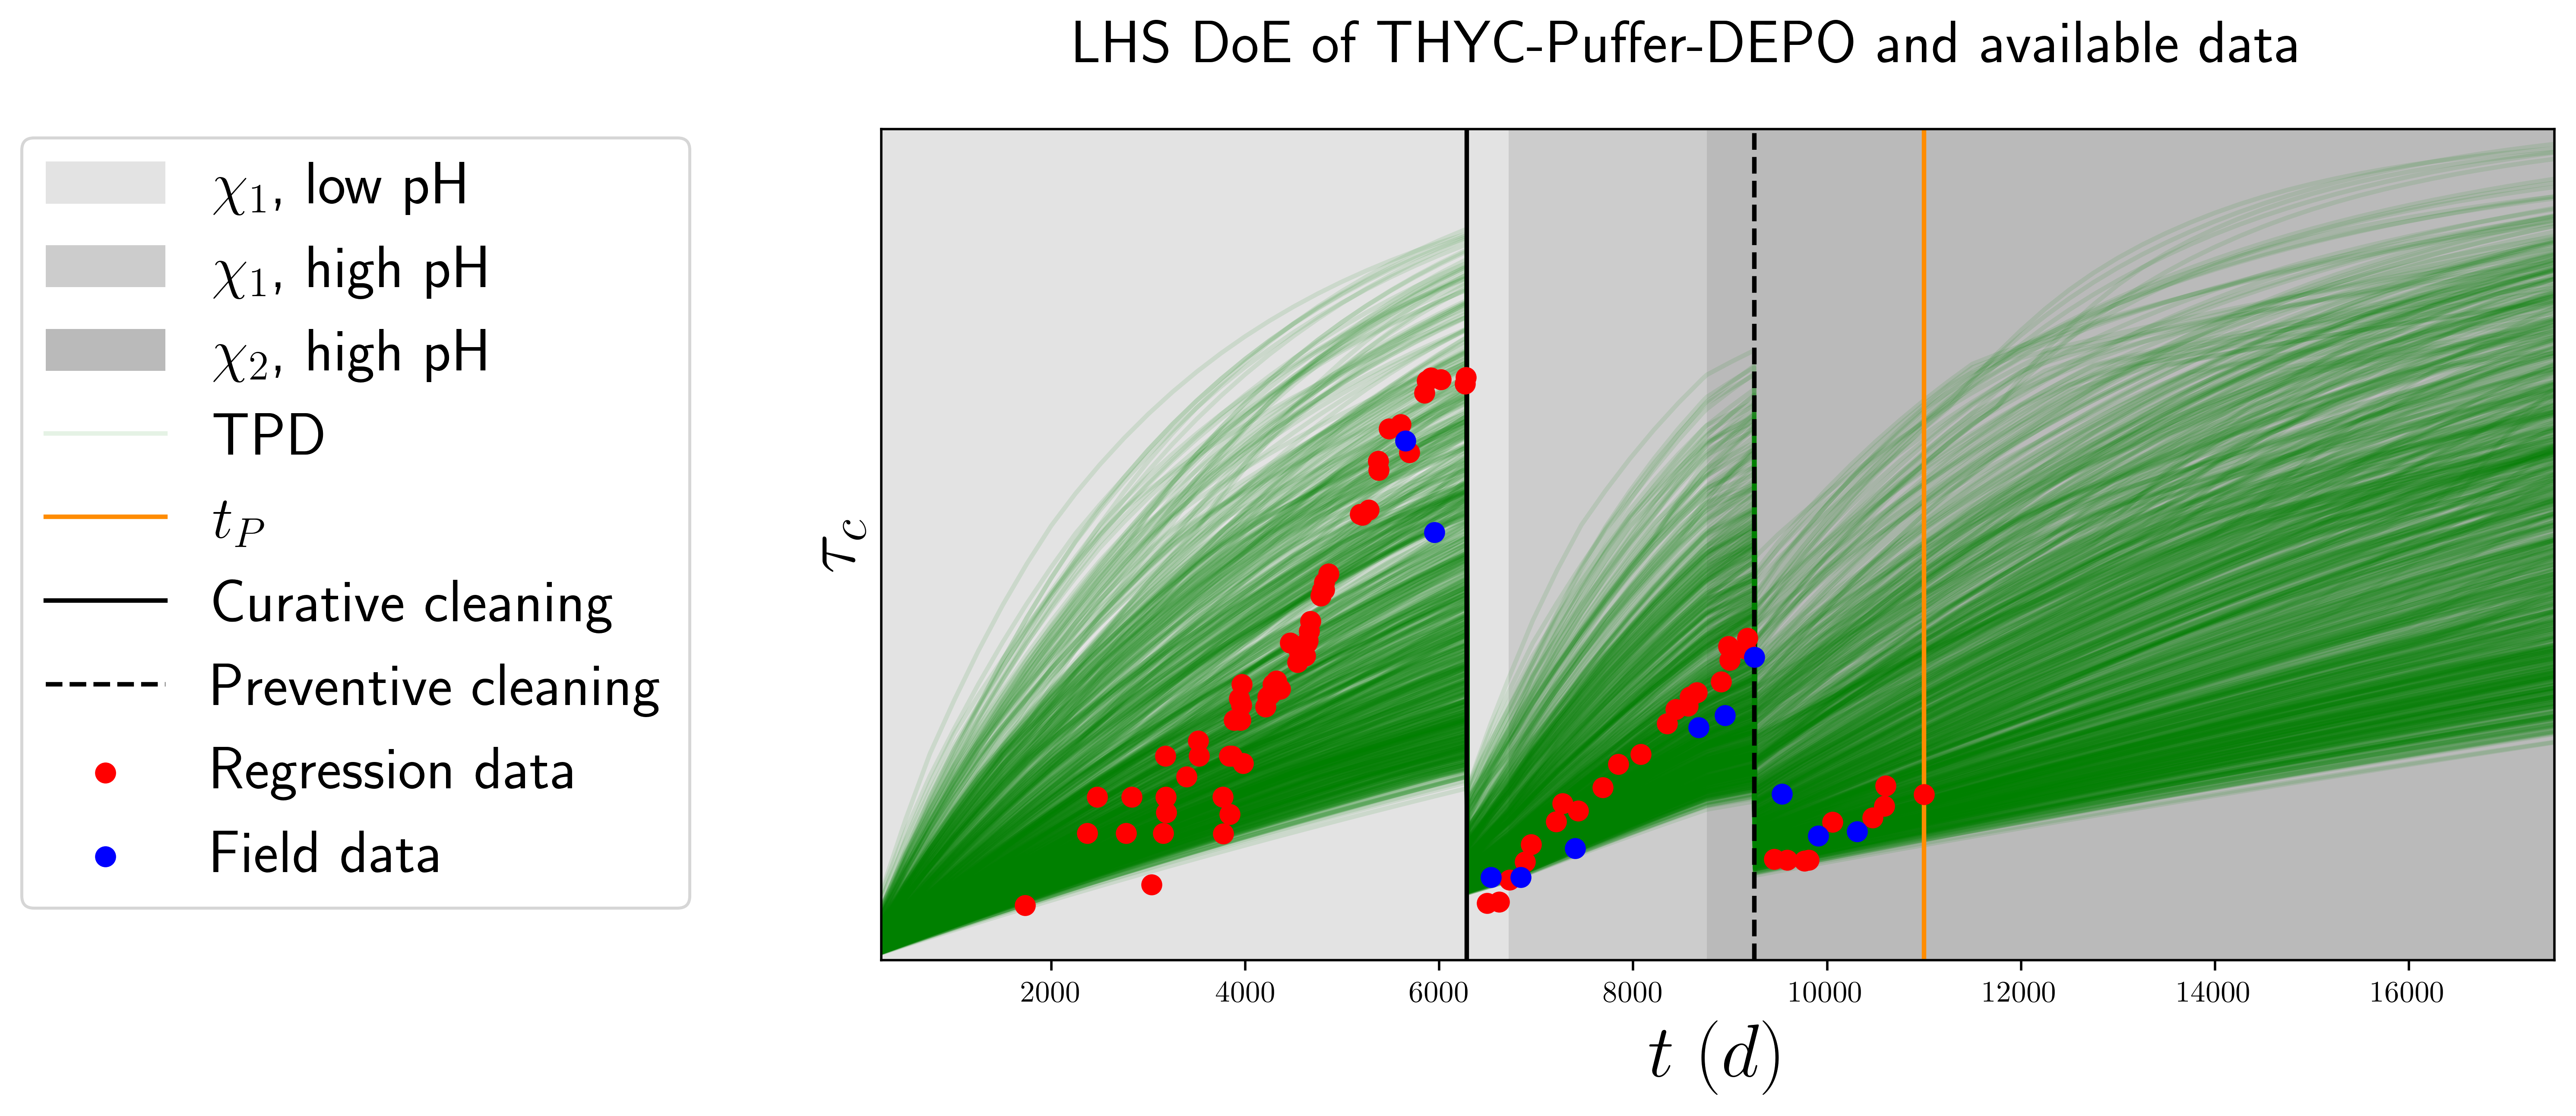

In [7]:
fig, axs = plt.subplots(1,1, figsize=(10,5))

axs = plot_tpd(axs, input_dic, y, SIMULATION_TIME, 'TPD')
for i in range(3):
    if i == 0:
        axs.scatter(data[i][0][:, 0], data[i][0][:, 1], color='red', label='Regression data', zorder=10)
        axs.scatter(data[i][1][:, 0], data[i][1][:, 1], color='blue', label='Field data', zorder=10)
    else:
        axs.scatter(data[i][0][:, 0], data[i][0][:, 1], color='red',  zorder=10)
        axs.scatter(data[i][1][:, 0], data[i][1][:, 1], color='blue', zorder=10)

axs.set_yticks([])
axs.grid(False)

lines_labels = [axs.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, bbox_to_anchor=(0.05,0.9), fontsize=20)

fig.suptitle('LHS DoE of THYC-Puffer-DEPO and available data', fontsize=20)

# Kernel-based given-data sensitivity analysis

In [13]:
hsic = HSIC(X, y)
threshold = 40

In [14]:
r2_hsic, p_val = hsic.r2_hsic()

In [15]:
target_r2_hsic, p_val_target = hsic.target_r2_hsic(target=threshold)

In [16]:
conditional_r2_hsic, p_val_conditional = hsic.conditional_r2_hsic(target=threshold)

## General $R^2_{HSIC}$

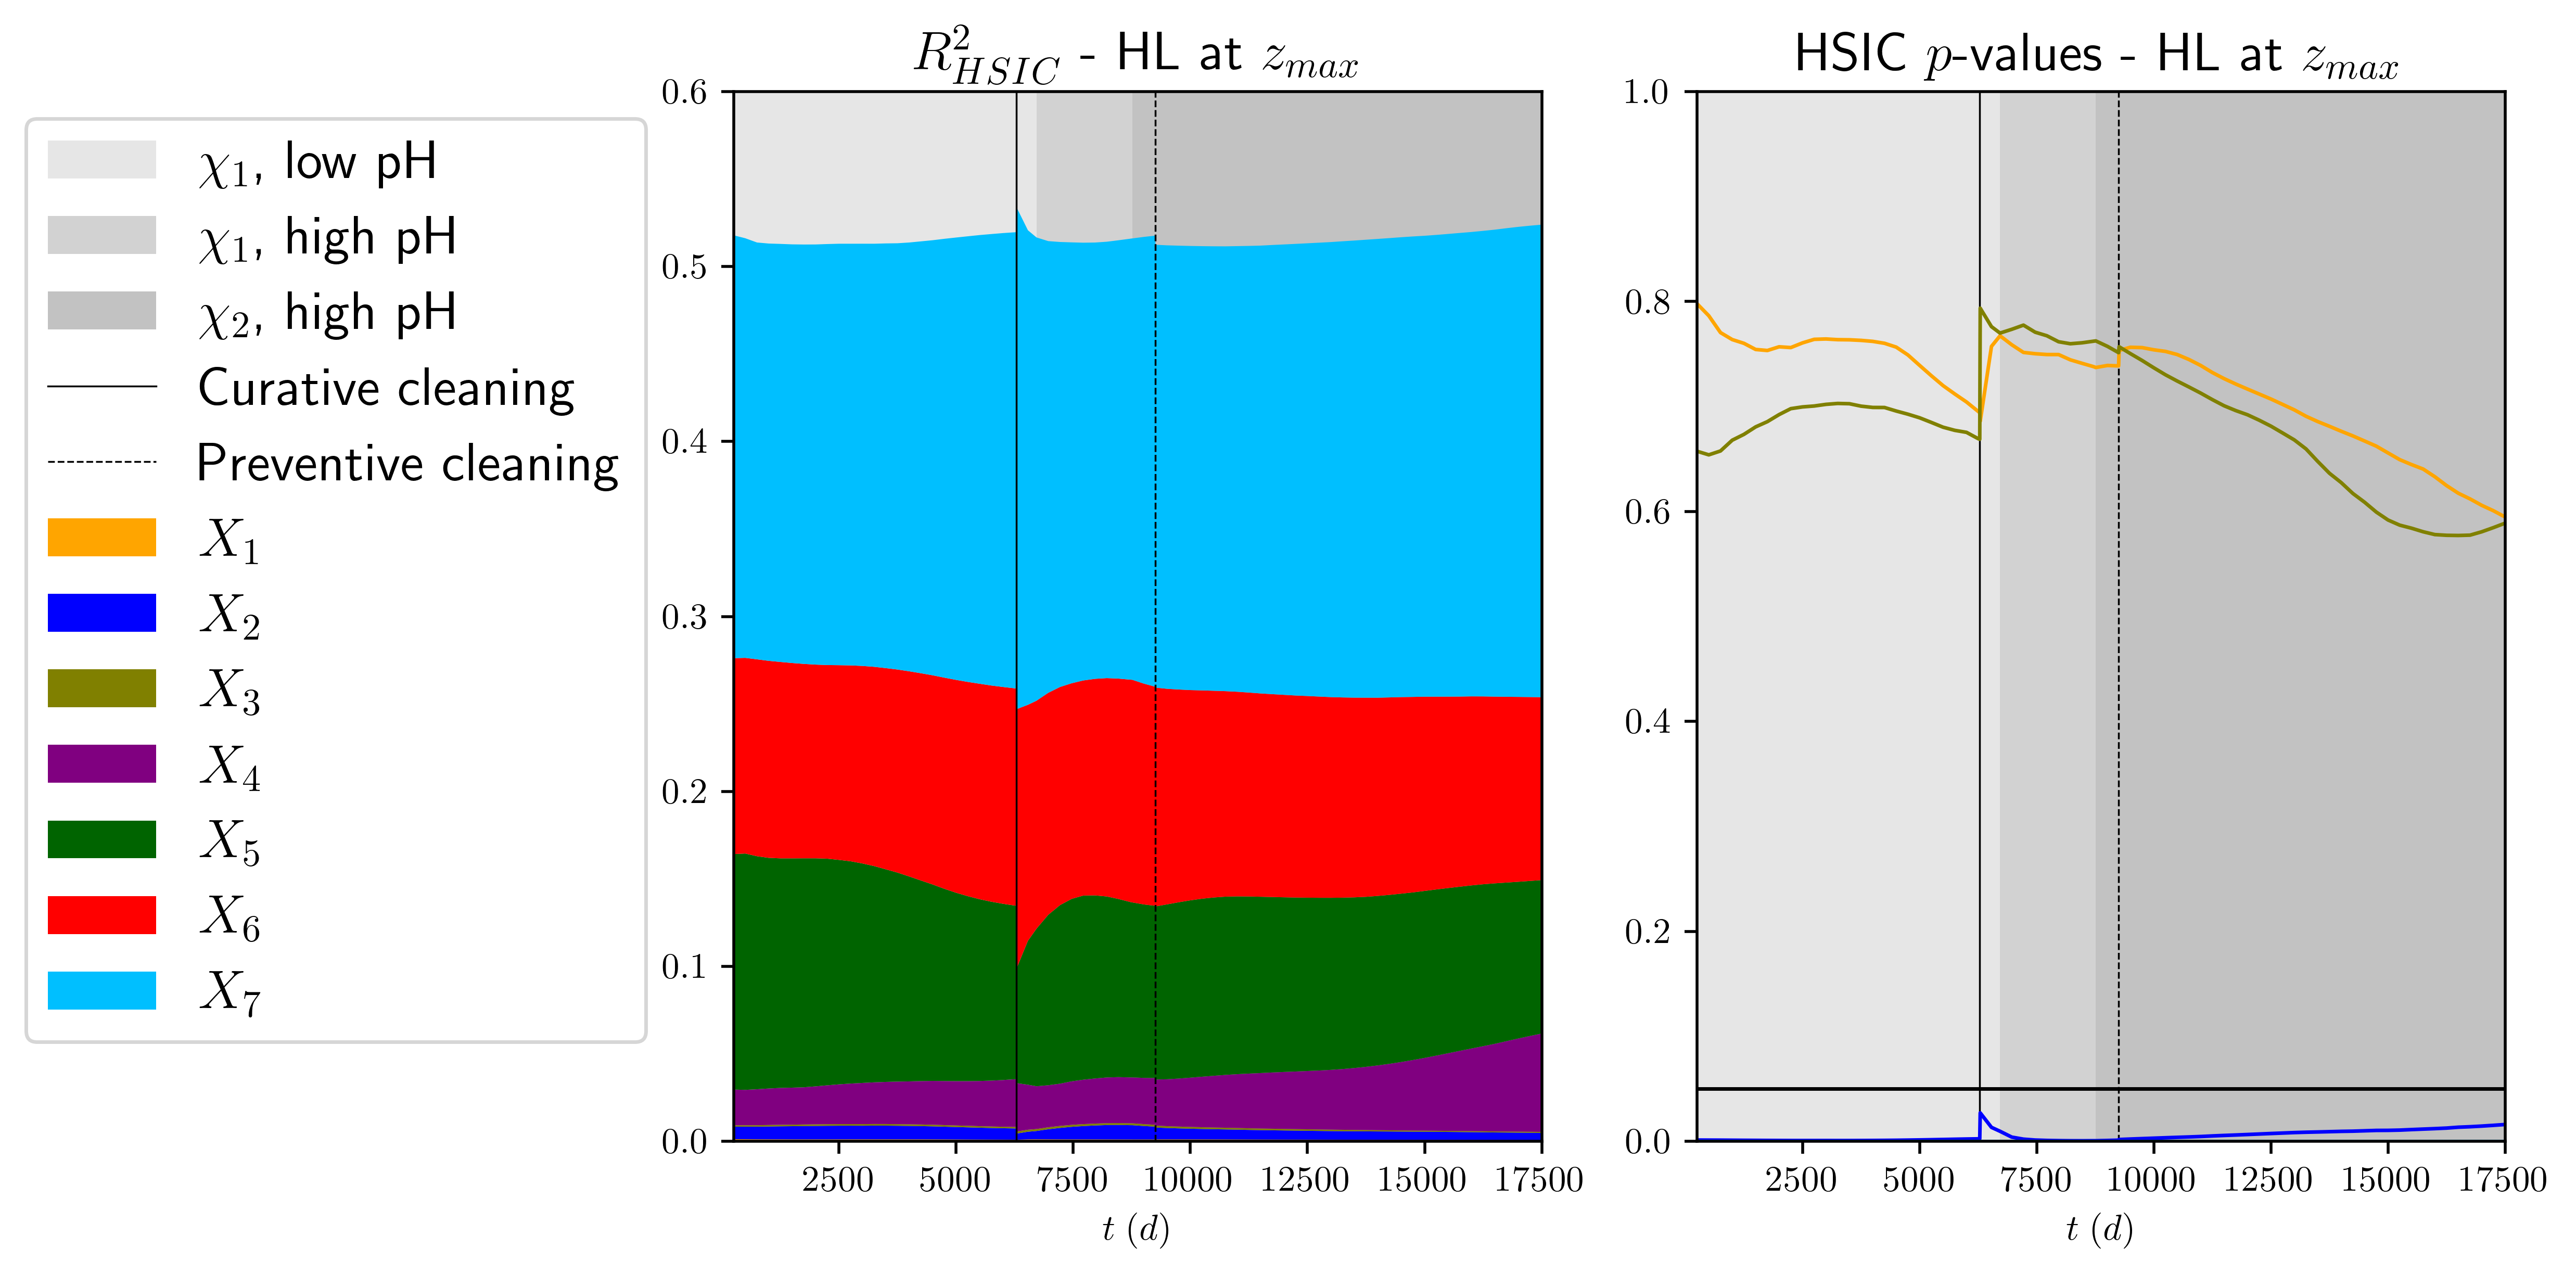

In [9]:
### FIG 10 ###

fig, axs = plt.subplots(1, 2, figsize=(10,5), layout='tight')
colors = ['orange', 'blue', 'olive','purple', 'darkgreen', 'red','deepskyblue']

#Chemical conditioning
cond = input_dic['chemistry']['conditioning']
for k in range(len(cond)):
    if k == len(cond)-1:
        t_i, t_f = cond[k]['time']/24, max(SIMULATION_TIME)
    else:
        t_i, t_f = cond[k]['time']/24, cond[k+1]['time']/24
    c = cond[k]
    typ = colors_n_chem_cond[c['type']]
    col = typ[str(c['ph'])]
    axs[0].axvspan(t_i, t_f, facecolor=col, alpha=0.7, label='{0}, {1} pH'.format(typ['name'], c['ph']))
    axs[1].axvspan(t_i, t_f, facecolor=col, alpha=0.7)

nett = input_dic['chemistry']['cleaning']
for k in range(len(nett)):
    if nett[k]['type'] == 'curative':
        axs[0].axvline(x=nett[k]['time']/24, color = 'k', linestyle='-', linewidth=0.5, label='Curative cleaning')
        axs[1].axvline(x=nett[k]['time']/24, color = 'k', linestyle='-', linewidth=0.5)
        
    elif nett[k]['type'] == 'preventive':
        axs[0].axvline(x=nett[k]['time']/24, color = 'k', linestyle='--', linewidth=0.5, label='Preventive cleaning')
        axs[1].axvline(x=nett[k]['time']/24, color = 'k', linestyle='--', linewidth=0.5)

axs[0].stackplot(SIMULATION_TIME, r2_hsic, labels=labels, colors=colors)
axs[0].set_xlim(250,17500)
axs[0].set_ylim(0,0.6)
axs[0].set_xlabel(r'$t\;(d)$')
axs[0].set_title(r'$R^{2}_{HSIC}$ - HL at $z_{max}$', fontsize=15)

for k in range(7):
    axs[1].plot(SIMULATION_TIME, p_val[k], c=colors[k], linewidth=1.0)
axs[1].set_xlim(250,17500)
axs[1].set_ylim(0,1.0)
axs[1].set_xlabel(r'$t\;(d)$')
axs[1].set_title(r'HSIC $p$-values - HL at $z_{max}$',  fontsize=15)

axs[0].legend(bbox_to_anchor=(-0.075,1.0), fontsize=15)

axs[1].axhline(y=0.05, linewidth=1.0, color='k', label=r'$p=0.05$')

#fig.savefig('../plots/HSIC/R2_HSIC_tot_asym.pdf', format='pdf', bbox_inches='tight')
#fig.savefig('../plots/HSIC/R2_HSIC_tot_asym.png', format='png', bbox_inches='tight')

## Target HSIC for safety threshold

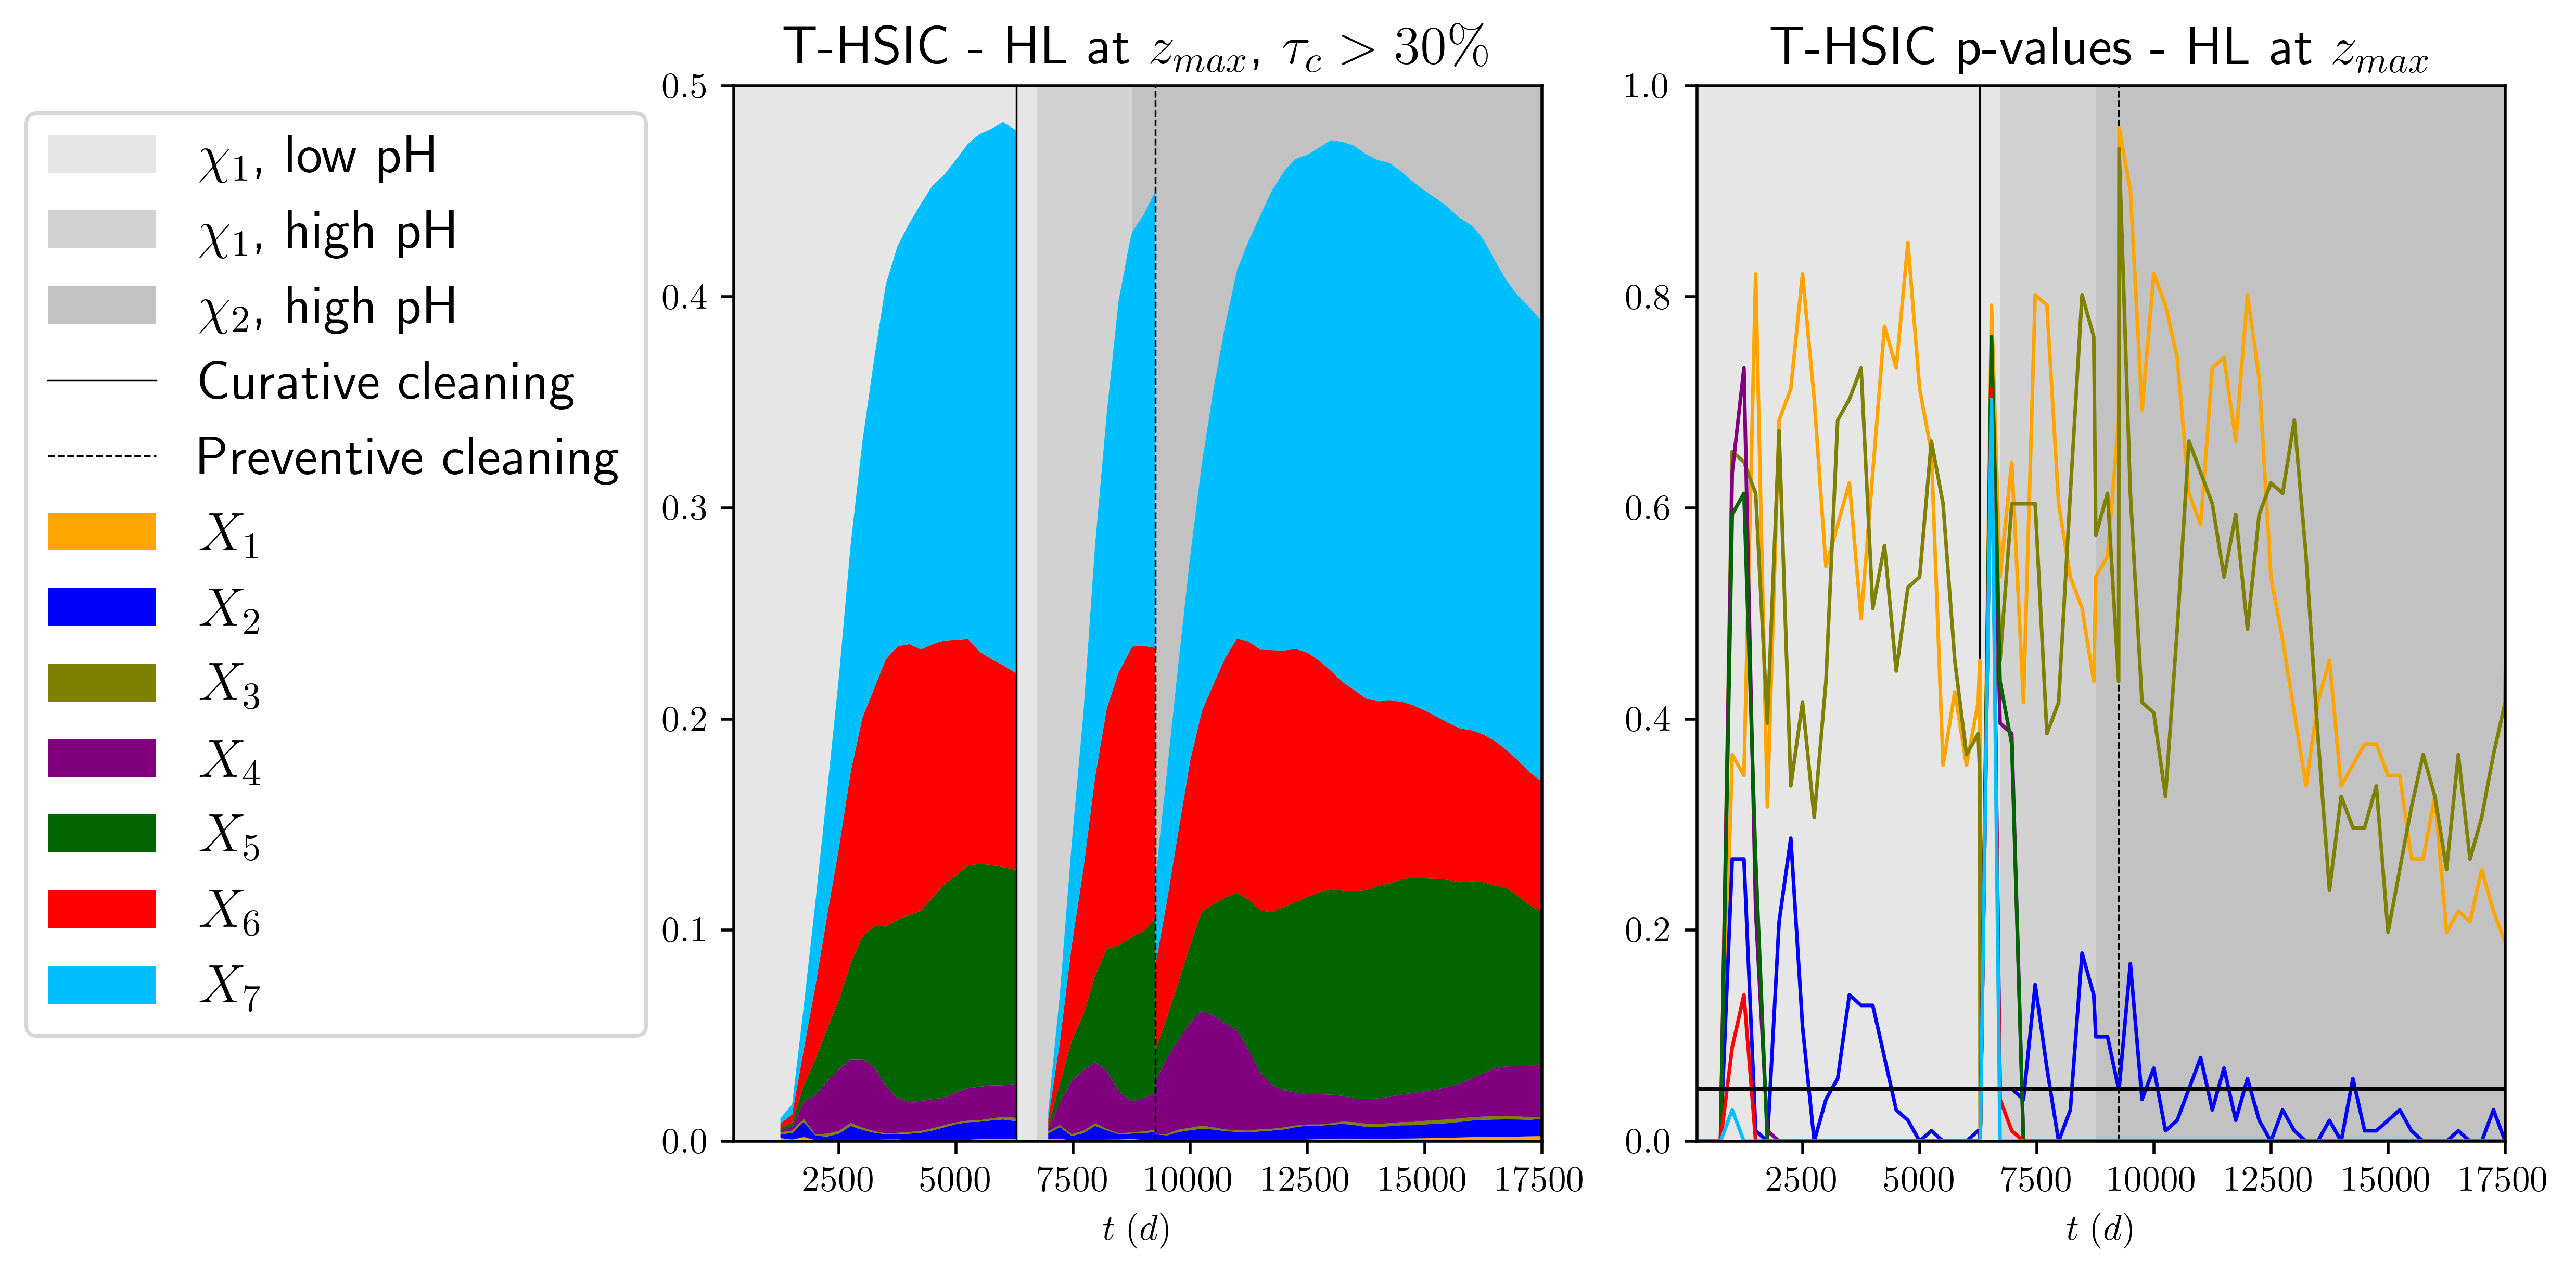

In [20]:
### FIG 11 ###

fig, axs = plt.subplots(1, 2, figsize=(10,5), layout='tight')
colors = ['orange', 'blue', 'olive','purple', 'darkgreen', 'red','deepskyblue']

#Chemical conditioning
cond = input_dic['chemistry']['conditioning']
for k in range(len(cond)):
    if k == len(cond)-1:
        t_i, t_f = cond[k]['time']/24, max(SIMULATION_TIME)
    else:
        t_i, t_f = cond[k]['time']/24, cond[k+1]['time']/24
    c = cond[k]
    typ = colors_n_chem_cond[c['type']]
    col = typ[str(c['ph'])]
    axs[0].axvspan(t_i, t_f, facecolor=col, alpha=0.7, label='{0}, {1} pH'.format(typ['name'], c['ph']))
    axs[1].axvspan(t_i, t_f, facecolor=col, alpha=0.7)

nett = input_dic['chemistry']['cleaning']
for k in range(len(nett)):
    if nett[k]['type'] == 'curative':
        axs[0].axvline(x=nett[k]['time']/24, color = 'k', linestyle='-', linewidth=0.5, label='Curative cleaning')
        axs[1].axvline(x=nett[k]['time']/24, color = 'k', linestyle='-', linewidth=0.5)
        
    elif nett[k]['type'] == 'preventive':
        axs[0].axvline(x=nett[k]['time']/24, color = 'k', linestyle='--', linewidth=0.5, label='Preventive cleaning')
        axs[1].axvline(x=nett[k]['time']/24, color = 'k', linestyle='--', linewidth=0.5)


axs[0].stackplot(SIMULATION_TIME, target_r2_hsic, labels=labels, colors=colors)
axs[0].set_xlim(250,17500)
axs[0].set_ylim(0,0.5)
axs[0].set_xlabel(r'$t\;(d)$')
axs[0].set_title(r'T-HSIC - HL at $z_{max}$, $\tau_c > 30\%$', fontsize=15)

#Target set size variation
#ax_ = axs[0].twinx()
#ax_.plot(SIMULATION_TIME, size_dataset[0], color = 'k', linewidth=1.0)
#ax_.set_xlim(250,17500)
#ax_.set_ylim(0,1000)
#ax_.set_ylim(0,1000)
#ax_.set_ylabel('Target set size', fontsize=15, rotation=270, labelpad=15)

for k in range(7):
    axs[1].plot(SIMULATION_TIME, p_val_target[k], c=colors[k], linewidth=1.0)
axs[1].set_xlim(250,17500)
axs[1].set_ylim(0,1.0)
axs[1].set_xlabel(r'$t\;(d)$')
axs[1].set_title(r'T-HSIC p-values - HL at $z_{max}$',  fontsize=15)

axs[0].legend(bbox_to_anchor=(-0.075,1.0), fontsize=15)

axs[1].axhline(y=0.05, linewidth=1.0, color='k', label=r'$p=0.05$')

#fig.savefig('../plots/HSIC/R2_HSIC_target.pdf', format='pdf', bbox_inches='tight')
#fig.savefig('../plots/HSIC/R2_HSIC_target.png', format='png', bbox_inches='tight')

# Conditional HSIC 

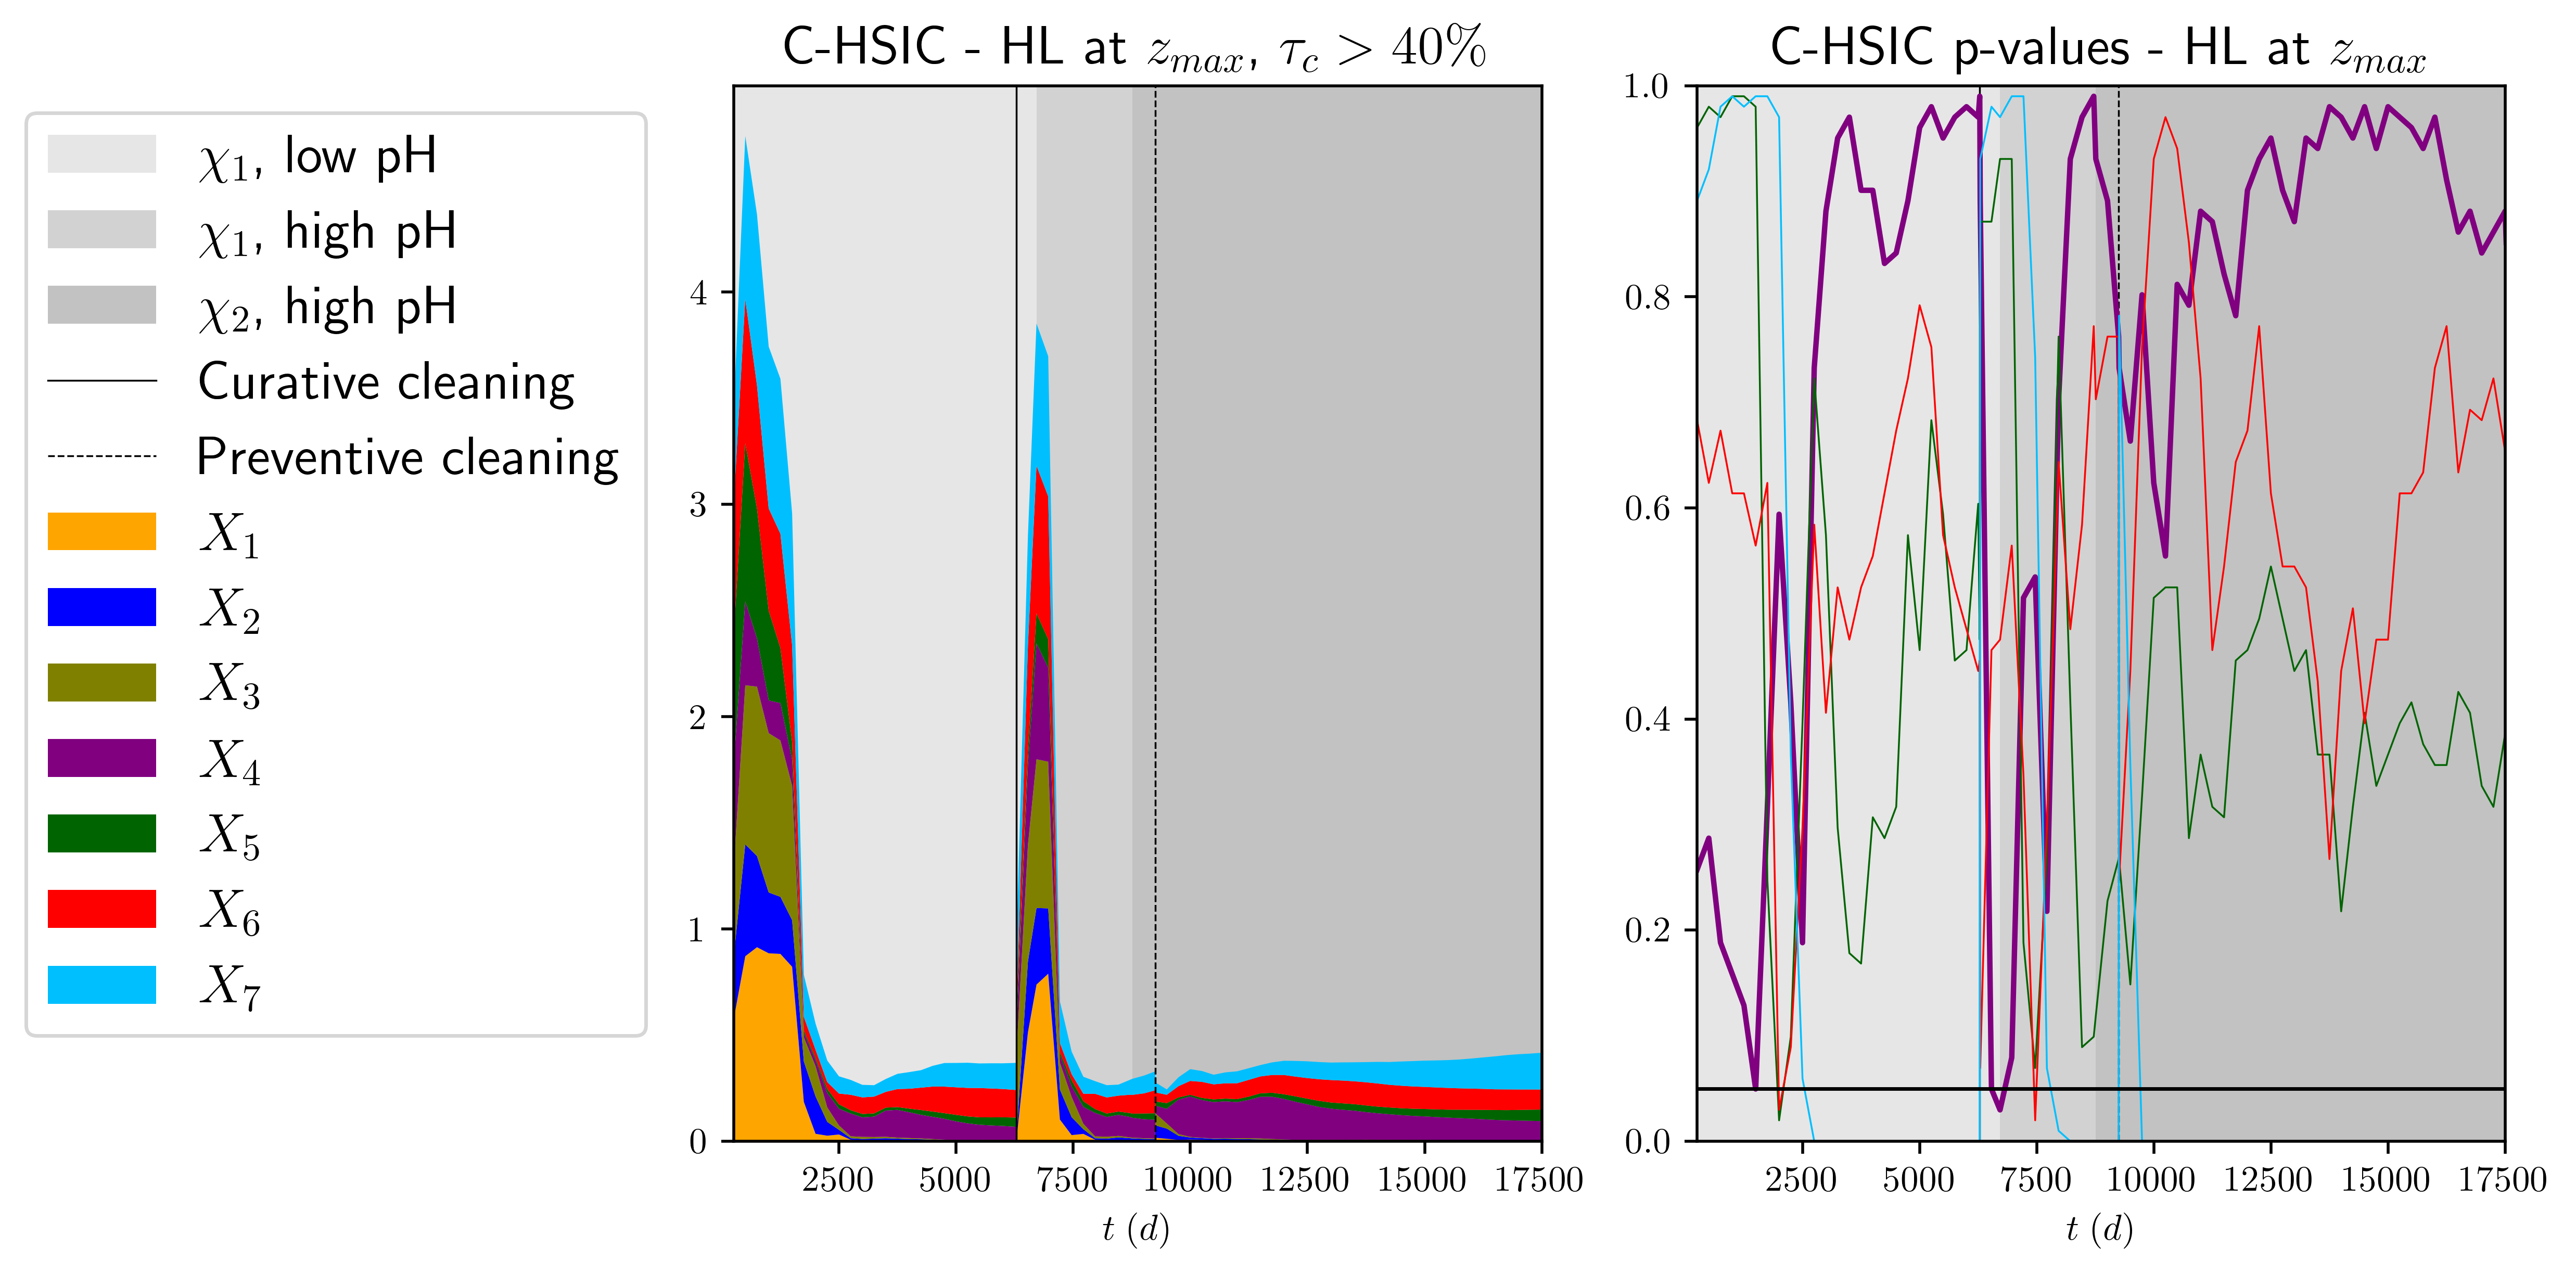

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(10,5), layout='tight')
colors = ['orange', 'blue', 'olive','purple', 'darkgreen', 'red','deepskyblue']

#Chemical conditioning
cond = input_dic['chemistry']['conditioning']
for k in range(len(cond)):
    if k == len(cond)-1:
        t_i, t_f = cond[k]['time']/24, max(SIMULATION_TIME)
    else:
        t_i, t_f = cond[k]['time']/24, cond[k+1]['time']/24
    c = cond[k]
    typ = colors_n_chem_cond[c['type']]
    col = typ[str(c['ph'])]
    axs[0].axvspan(t_i, t_f, facecolor=col, alpha=0.7, label='{0}, {1} pH'.format(typ['name'], c['ph']))
    axs[1].axvspan(t_i, t_f, facecolor=col, alpha=0.7)

nett = input_dic['chemistry']['cleaning']
for k in range(len(nett)):
    if nett[k]['type'] == 'curative':
        axs[0].axvline(x=nett[k]['time']/24, color = 'k', linestyle='-', linewidth=0.5, label='Curative cleaning')
        axs[1].axvline(x=nett[k]['time']/24, color = 'k', linestyle='-', linewidth=0.5)
        
    elif nett[k]['type'] == 'preventive':
        axs[0].axvline(x=nett[k]['time']/24, color = 'k', linestyle='--', linewidth=0.5, label='Preventive cleaning')
        axs[1].axvline(x=nett[k]['time']/24, color = 'k', linestyle='--', linewidth=0.5)

axs[0].stackplot(SIMULATION_TIME, conditional_r2_hsic, labels=labels, colors=colors)
axs[0].set_xlim(250,17500)
#axs[0].set_ylim(0,0.5)
axs[0].set_xlabel(r'$t\;(d)$')
axs[0].set_title(r'C-HSIC - HL at $z_{max}$, $\tau_c > 40\%$', fontsize=15)

#ax_ = axs[0].twinx()
#ax_.plot(SIMULATION_TIME, size_dataset[0], color = 'k', linewidth=1.0)
#ax_.set_xlim(250,17500)
#ax_.set_ylim(0,1000)
#ax_.set_ylabel('Target set size', fontsize=15, rotation=270, labelpad=15)
#ax_.set_ylim(0,1000)

for k in range(4):
    if k == 0:
        axs[1].plot(SIMULATION_TIME, p_val_conditional[k], c=colors[k+3], linewidth=1.5)
    else:   
        axs[1].plot(SIMULATION_TIME, p_val_conditional[k], c=colors[k+3], linewidth=0.5)
axs[1].set_xlim(250,17500)
axs[1].set_ylim(0,1.0)
axs[1].set_xlabel(r'$t\;(d)$')
axs[1].set_title(r'C-HSIC p-values - HL at $z_{max}$',  fontsize=15)

axs[0].legend(bbox_to_anchor=(-0.075,1.0), fontsize=15)

axs[1].axhline(y=0.05, linewidth=1.0, color='k', label=r'$p=0.05$')

#fig.savefig('../plots/HSIC/R2_HSIC_cond.pdf', format='pdf', bbox_inches='tight')
#fig.savefig('../plots/HSIC/R2_HSIC_cond.png', format='png', bbox_inches='tight')

# updated distribution

In [3]:
y = np.load(BASE_DIRECTORY + 'y.npy')
sample = np.load(BASE_DIRECTORY + 'sample.npy')
sample_1 = np.load(BASE_DIRECTORY + 'sample_1.npy')
sample_2 = np.load(BASE_DIRECTORY + 'sample_2.npy')
sample_3 = np.load(BASE_DIRECTORY + 'sample_3.npy')
y_new = np.load(BASE_DIRECTORY + 'y_new.npy')

In [4]:
hsic_time_prior = []
p_values_prior, p_values_posterior = []
#U-statistic is better optimized in OpenTURNS for HSIC
estimatorType_u = ot.HSICUStat() 

In [ ]:
for i in range(75):
    
    tauSample = ot.Sample(y[:,i].reshape(-1,1))
    covarianceModelCollection_HL = []

    for i in range(7):
        Xi = ot.Sample(sample[:, i].reshape(-1,1))
        Cov = ot.SquaredExponential(1) #Use of squared exponential (Gaussian) kernel
        Cov.setScale(Xi.computeStandardDeviation())
        covarianceModelCollection_HL.append(Cov)

    covarianceModelCollection_HL.append(ot.SquaredExponential(tauSample.computeStandardDeviation()))

    hsic_u = ot.HSICEstimatorGlobalSensitivity(covarianceModelCollection_HL, sample, tauSample, estimatorType_u)

    hsic_time_prior.append(list(np.abs(hsic_u.getR2HSICIndices())))

    #Asymptotic p-value test
    p_values_prior.append(hsic_u.getPValuesAsymptotic())

In [10]:
nc1 = np.where((SIMULATION_TIME*24).astype(int) == 150792)[0][0]
nc2 = np.where((SIMULATION_TIME*24).astype(int) == 221928)[0][0]

In [16]:
hsic_time_posterior_1, hsic_time_posterior_2, hsic_time_posterior_3 = [], [], []
p_values_posterior_1, p_values_posterior_2, p_values_posterior_3 = [], [], []

In [17]:
for i in range(75):
    
    tauSample = ot.Sample(y_new[:,i].reshape(-1,1))

    covarianceModelCollection_1 = []
    covarianceModelCollection_2 = []
    covarianceModelCollection_3 = []

    for i in range(7):
        Xi_1 = ot.Sample(sample_1[:, i].reshape(-1,1))
        Xi_2 = ot.Sample(sample_2[:, i].reshape(-1,1))
        Xi_3 = ot.Sample(sample_3[:, i].reshape(-1,1))
        Cov_1, Cov_2, Cov_3 = ot.SquaredExponential(1), ot.SquaredExponential(1), ot.SquaredExponential(1)
        Cov_1.setScale(Xi_1.computeStandardDeviation())
        Cov_2.setScale(Xi_2.computeStandardDeviation())
        Cov_3.setScale(Xi_3.computeStandardDeviation())
        covarianceModelCollection_1.append(Cov_1)
        covarianceModelCollection_2.append(Cov_2)
        covarianceModelCollection_3.append(Cov_3)

    covarianceModelCollection_1.append(ot.SquaredExponential(tauSample.computeStandardDeviation()))
    covarianceModelCollection_2.append(ot.SquaredExponential(tauSample.computeStandardDeviation()))
    covarianceModelCollection_3.append(ot.SquaredExponential(tauSample.computeStandardDeviation()))

    hsic_u_1 = ot.HSICEstimatorGlobalSensitivity(covarianceModelCollection_1, sample_1, tauSample, estimatorType_u)
    hsic_u_2 = ot.HSICEstimatorGlobalSensitivity(covarianceModelCollection_2, sample_2, tauSample, estimatorType_u)
    hsic_u_3 = ot.HSICEstimatorGlobalSensitivity(covarianceModelCollection_3, sample_3, tauSample, estimatorType_u)
    
    hsic_time_posterior_1.append(list(np.abs(hsic_u_1.getR2HSICIndices())))
    hsic_time_posterior_2.append(list(np.abs(hsic_u_2.getR2HSICIndices())))
    hsic_time_posterior_3.append(list(np.abs(hsic_u_3.getR2HSICIndices())))

    #Asymptotic p-value test
    p_values_posterior_1.append(hsic_u_1.getPValuesAsymptotic())
    p_values_posterior_2.append(hsic_u_2.getPValuesAsymptotic())
    p_values_posterior_3.append(hsic_u_3.getPValuesAsymptotic())

In [22]:
hsic_time_posterior_1 = np.asarray(hsic_time_posterior_1).T
hsic_time_posterior_2 = np.asarray(hsic_time_posterior_2).T
hsic_time_posterior_3 = np.asarray(hsic_time_posterior_3).T

p_values_posterior_1 = np.asarray(p_values_posterior_1).T
p_values_posterior_2 = np.asarray(p_values_posterior_2).T
p_values_posterior_3 = np.asarray(p_values_posterior_3).T

In [27]:
hsic_posterior = np.concatenate((hsic_time_posterior_1[:,:nc1+1], np.concatenate((hsic_time_posterior_2[:,nc1+1:nc2+1], hsic_time_posterior_3[:,nc2+1:]), axis=1)), axis=1)
p_values_posterior = np.concatenate((p_values_posterior_1[:,:nc1+1], np.concatenate((p_values_posterior_2[:,nc1+1:nc2+1], p_values_posterior_3[:,nc2+1:]), axis=1)), axis=1)

In [32]:
hsic_time_prior = np.asarray(hsic_time_prior).T

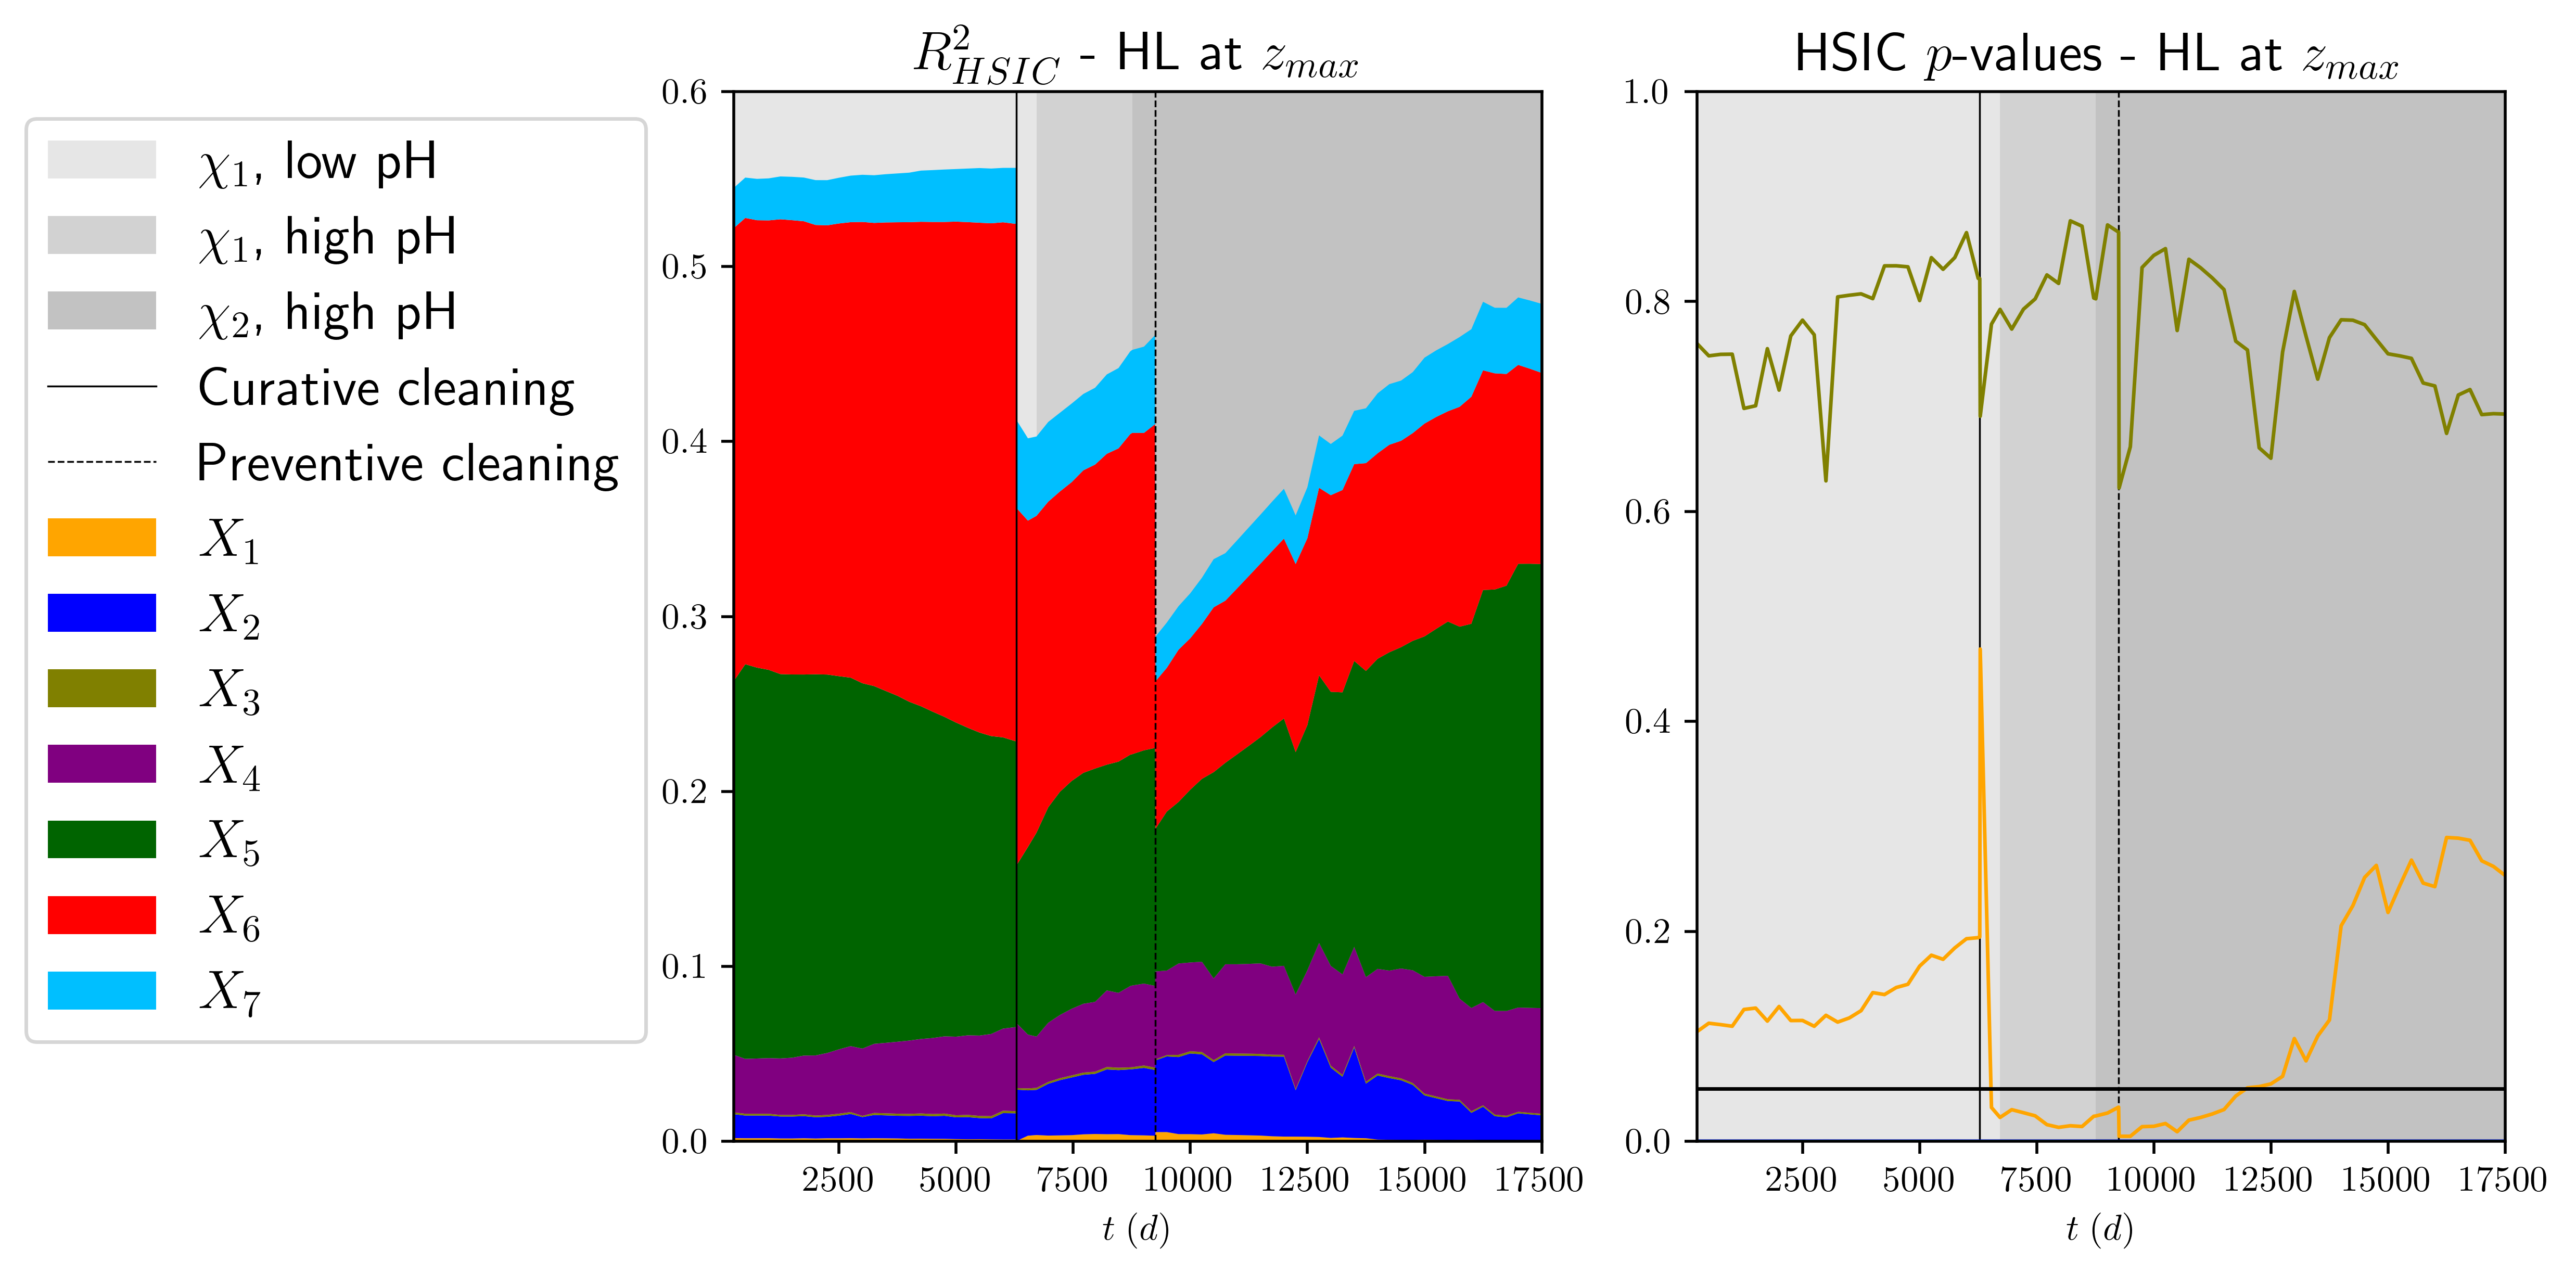

In [34]:
### FIG 10 ###

fig, axs = plt.subplots(1, 2, figsize=(10,5), layout='tight')
colors = ['orange', 'blue', 'olive','purple', 'darkgreen', 'red','deepskyblue']

#Chemical conditioning
cond = input_dic['chemistry']['conditioning']
for k in range(len(cond)):
    if k == len(cond)-1:
        t_i, t_f = cond[k]['time']/24, max(SIMULATION_TIME)
    else:
        t_i, t_f = cond[k]['time']/24, cond[k+1]['time']/24
    c = cond[k]
    typ = colors_n_chem_cond[c['type']]
    col = typ[str(c['ph'])]
    axs[0].axvspan(t_i, t_f, facecolor=col, alpha=0.7, label='{0}, {1} pH'.format(typ['name'], c['ph']))
    axs[1].axvspan(t_i, t_f, facecolor=col, alpha=0.7)

nett = input_dic['chemistry']['cleaning']
for k in range(len(nett)):
    if nett[k]['type'] == 'curative':
        axs[0].axvline(x=nett[k]['time']/24, color = 'k', linestyle='-', linewidth=0.5, label='Curative cleaning')
        axs[1].axvline(x=nett[k]['time']/24, color = 'k', linestyle='-', linewidth=0.5)
        
    elif nett[k]['type'] == 'preventive':
        axs[0].axvline(x=nett[k]['time']/24, color = 'k', linestyle='--', linewidth=0.5, label='Preventive cleaning')
        axs[1].axvline(x=nett[k]['time']/24, color = 'k', linestyle='--', linewidth=0.5)

axs[0].stackplot(SIMULATION_TIME, hsic_posterior, labels=labels, colors=colors)
axs[0].set_xlim(250,17500)
axs[0].set_ylim(0,0.6)
axs[0].set_xlabel(r'$t\;(d)$')
axs[0].set_title(r'$R^{2}_{HSIC}$ - HL at $z_{max}$', fontsize=15)

for k in range(7):
    axs[1].plot(SIMULATION_TIME, p_values_posterior[k], c=colors[k], linewidth=1.0)
axs[1].set_xlim(250,17500)
axs[1].set_ylim(0,1.0)
axs[1].set_xlabel(r'$t\;(d)$')
axs[1].set_title(r'HSIC $p$-values - HL at $z_{max}$',  fontsize=15)

axs[0].legend(bbox_to_anchor=(-0.075,1.0), fontsize=15)

axs[1].axhline(y=0.05, linewidth=1.0, color='k', label=r'$p=0.05$')

#fig.savefig('../plots/HSIC/R2_HSIC_tot_asym.pdf', format='pdf', bbox_inches='tight')
#fig.savefig('../plots/HSIC/R2_HSIC_tot_asym.png', format='png', bbox_inches='tight')